### PROJETO 01: DETECÇÃO DE FRAUDES NO TRÁFEGO DE CLIQUES EM PROPAGANDAS DE APLICAÇÕES MOBILE

![<caption>](TalkingData.PNG)

A TalkingData (https://www.talkingdata.com), a maior plataforma de big data independente da china, cobre mais de 70% dos dispositivos móveis ativos em todo o país. Eles lidam com 3 bilhões de cliques por dia, dos quais 90% são potencialmente fraudulentos. Sua abordagem atual para impedir fraudes de cliques para desenvolvedores de aplicativos é medir a jornada do clique de um usuário em todo o portifólio e sinalizar endereços ip que produzem muitos cliques, mas nunca acabam instalando aplicativos. Com essas informações, eles criaram uma lista negra de ips e uma lista negra de dispositivos. Embora bem-sucedidos, eles querem estar sempre um passo à frente dos fraudadores e pretedem desenvolver ainda mais a solução. Então, neste projeto, o objetivo é construir um modelo de aprendizado de máquina para determinar se um clique é fraudulento ou não.


**Descrição dos Dados**

Os dados de treino foram coletados do dataset train.csv do Kaggle. Além de coletar amostras, foi realizada fiz modificações nos nomes das variáveis para uma melhor compreenssão delas.

Dados de Treino:

Cada linha dos dados de treinamento contém um registro de cliques, com os seguintes recursos.

- IP: ip endereço de clique.
- App: id de aplicativo para marketing.
- Dispositivo: identificação do tipo de dispositivo do celular do usuário (por exemplo, iphone 6 plus, iphone 7, huawei mate 7, etc.)
- SO: id versão do sistema operacional do celular do usuário
- Canal: id do canal da editora de anúncios móveis
- Horario_clique: fuso de hora em hora (UTC)
- Horario_download: se o usuário baixar o aplicativo para depois de clicar em um anúncio, esta é a hora do download do aplicativo
- Classe: o alvo a ser previsto, indicando que o aplicativo foi baixado

### PRÉ-PROCESSAMENTO E ANÁLISE DOS DADOS

#### **DIRETÓRIO DE TRABALHO E CARREGAMENTO DE BIBLIOTECAS**

In [1]:
# DIRETÓRIO DE TRABALHO
setwd('C:/FCD/DataScienceAcademy/BigDataRAzure/Projeto1')
getwd()

[1] "C:/FCD/DataScienceAcademy/BigDataRAzure/Projeto1"

In [2]:
# DESATIVAR MENSAGENS DE WARNINGS (warn = -1) E ATIVAR (warn = 0)
options(warn = -1)

In [3]:
# DESATIVA NOTAÇÃO CIENTÍFICA
options(scipen = 999)

In [4]:
# PARA TAMANHO DOS GRÁFICOS
options(jupyter.plot_scale = 1)

In [5]:
# CARREGANDO BIBLIOTECAS 
suppressPackageStartupMessages({
library(dplyr)
library(tidyr)
library(data.table)
library(readr)
library(ggplot2)
library(gridExtra)
library(scales) # Função date_format()
library(lubridate)
library(caret)
library(e1071)
library(class)
library(caTools) # Função sample.spli()
library(ROCR)
})

#### CARREGANDO OS DADOS

In [6]:
# CARREGANDO df_Talking_Data
df_Talking_Data <- fread("df_Talking_Data.csv")
glimpse(df_Talking_Data)

Rows: 240,000
Columns: 8
$ IP               <int> 95766, 43793, 32453, 314022, 40241, 197004, 106770, 5~
$ App              <int> 18, 29, 18, 39, 3, 5, 18, 3, 14, 18, 14, 1, 17, 19, 1~
$ Dispositivo      <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 2,~
$ SO               <int> 20, 19, 18, 19, 8, 11, 20, 10, 25, 32, 19, 13, 13, 38~
$ Canal            <int> 107, 213, 107, 213, 280, 113, 107, 280, 379, 121, 379~
$ Horario_clique   <chr> "2017-11-08 02:34:42", "2017-11-08 14:38:44", "2017-1~
$ Horario_download <chr> NA, "2017-11-08 14:47:49", "2017-11-09 12:48:00", "20~
$ Classe           <int> 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,~


In [7]:
# TRANSFORMANDO COLUNAS DE STRING EM DATA
df_Talking_Data$Horario_clique <- as_datetime(df_Talking_Data$Horario_clique)
df_Talking_Data$Horario_download <- as_datetime(df_Talking_Data$Horario_download)

In [8]:
glimpse(df_Talking_Data)

Rows: 240,000
Columns: 8
$ IP               <int> 95766, 43793, 32453, 314022, 40241, 197004, 106770, 5~
$ App              <int> 18, 29, 18, 39, 3, 5, 18, 3, 14, 18, 14, 1, 17, 19, 1~
$ Dispositivo      <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 2,~
$ SO               <int> 20, 19, 18, 19, 8, 11, 20, 10, 25, 32, 19, 13, 13, 38~
$ Canal            <int> 107, 213, 107, 213, 280, 113, 107, 280, 379, 121, 379~
$ Horario_clique   <dttm> 2017-11-08 02:34:42, 2017-11-08 14:38:44, 2017-11-09~
$ Horario_download <dttm> NA, 2017-11-08 14:47:49, 2017-11-09 12:48:00, 2017-1~
$ Classe           <int> 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,~


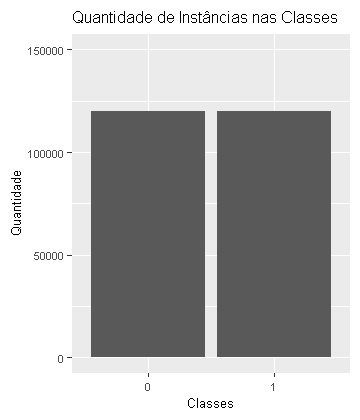

In [9]:
# QUANTIDADE DE INSTÂNCIAS EM CADA CLASSES
g0 <- ggplot(df_Talking_Data, aes(x = as.factor(Classe))) +
     geom_bar(stat = 'count') +
     coord_cartesian(ylim = c(0, 150000)) +
     labs(title = "Quantidade de Instâncias nas Classes",x = 'Classes', y = 'Quantidade') +
     theme(text = element_text(size = 8))

options(repr.plot.width = 3.0, repr.plot.height = 3.5)
g0

#### CLIQUES SEM DOWNLOAD

In [10]:
## SLICE DATASET - APLICATIVO NÃO BAIXADO
df_nao_baixado <- df_Talking_Data[df_Talking_Data$Classe == 0,]
df_nao_baixado$Classe <- as.factor(df_nao_baixado$Classe)

In [11]:
# FUNÇÃO PARA PLOTAGEM DO GRÁFICO DE BARRAS
grafico_barras <- function(x, xlab, title){
    ggplot(x[1:15,], aes(x = reorder(Var1, Freq), y = Freq)) +
    geom_bar(stat = "identity") + labs(x = xlab, y = "Quantidade de Cliques", title = title) +
    theme_minimal() +
    theme( plot.title = element_text(hjust = 0.5), text = element_text(size = 8)) +
    coord_flip()
}

In [12]:
# IP 
ip <- data.frame(table(df_nao_baixado$IP))
ip <- ip[order(ip$Freq, decreasing = T),]

# IP E NÚMERO DE CLIQUES QUE NÃO BAIXARAM O APLICATIVO 
# 15 PRIMEIROS IPs DE MAIOR NÚMERO DE CLIQUES 
g1 = grafico_barras(ip, "IP", "IP sem download")

In [13]:
# ID APP 
id_aplicativo <- data.frame(table(df_nao_baixado$App))
id_aplicativo <- id_aplicativo[order(id_aplicativo$Freq, decreasing = T),]

# IDs DE APP E NÚMERO DE CLIQUES QUE NÃO BAIXARAM O APLICATIVO 
# 15 PRIMEIROS IDs DE APP DE MAIOR NÚMERO DE CLIQUES 
g2 = grafico_barras(id_aplicativo, "App", "App e cliques sem download")

In [14]:
# ID DISPOSITIVO
identificacao_dispositivo <- data.frame(table(df_nao_baixado$Dispositivo))
identificacao_dispositivo <- identificacao_dispositivo[order(identificacao_dispositivo$Freq, decreasing = T),]

# IDs DOS DISPOSITIVOS E VOLUME DE CLIQUES QUE NÃO BAIXARAM O APLICATIVO 
# 15 PRIMEIROS IDs DE DISPOSITIVOS DE MAIOR NÚMERO DE CLIQUES
g3 = grafico_barras(identificacao_dispositivo, "Dispositivo", "Dispositivo e cliques sem download")

In [15]:
# ID SISTEMA OPERACIONAL
id_sistema_operacional <- data.frame(table(df_nao_baixado$SO))
id_sistema_operacional <- id_sistema_operacional[order(id_sistema_operacional$Freq, decreasing = T),]

# IDs DO SISTEMA OPERACIONAL E VOLUME DE CLIQUES QUE NÃO BAIXARAM O APLICATIVO 
# 15 PRIMEIROS IDs DE SISTEMA OPERACIONAL DE MAIOR NÚMERO DE CLIQUES
g4 <- grafico_barras(id_sistema_operacional, "SO", "SO e cliques sem download")

In [16]:
# ID CANAL 
id_canal <- data.frame(table(df_nao_baixado$Canal))
id_canal <- id_canal [order(id_canal$Freq, decreasing = T),]

# IDs DE CANAL E VOLUME DE CLIQUES QUE NÃO BAIXARAM O APLICATIVO
# 15 PRIMEIROS IDs DE CANAL EM QUE SE TEVE MAIOR NÚMERO DE CLIQUES
g5 <- grafico_barras(id_canal, "Canal", "Canal e cliques sem download")

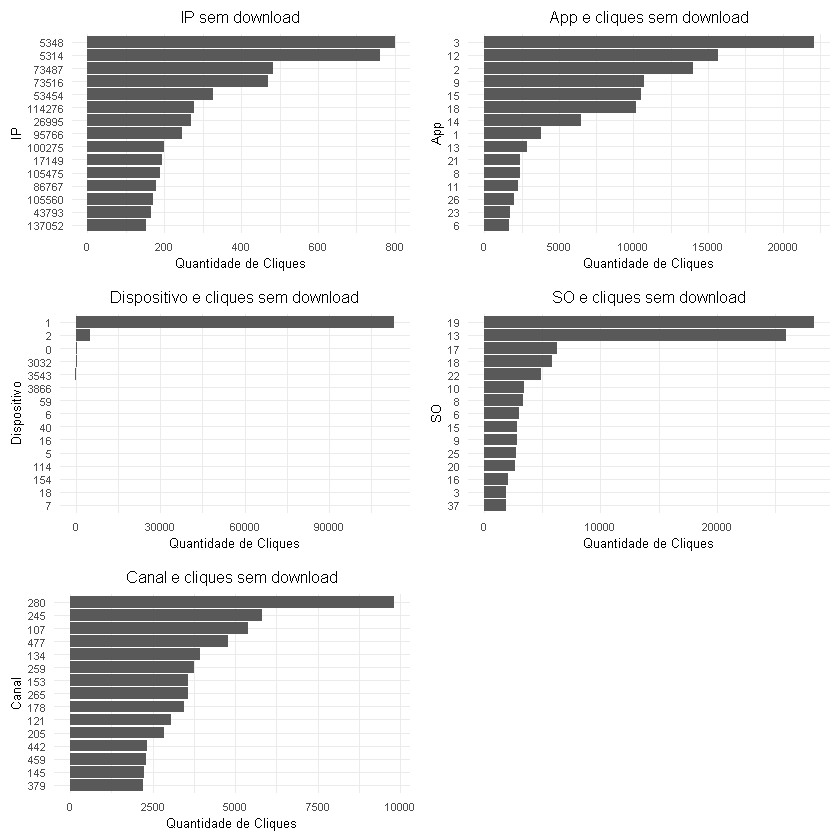

In [17]:
options(repr.plot.width = 7, repr.plot.height = 7)
grid.arrange(g1, g2, g3, g4, g5)

O tipo de dispositivo 1 é o que mais está associado à cliques sem downloads. Os IDs do sistema operacional 19 e 13 são os mais associados à cliques sem downloads. Já o canal em que mais se tem cliques sem downloads é o 280.

In [18]:
# PERÍODO DE CLIQUES SEM DOWNLOAD CONFORME AMOSTRA COLETADA - DATA E HORÁRIO
df_cliques_sem_download = df_Talking_Data[df_Talking_Data$Classe == 0,]
inicio <- min(df_cliques_sem_download$Horario_clique)
fim <- max(df_cliques_sem_download$Horario_clique)
cat(sprintf("De: %s", inicio))
cat(sprintf("\nAté: %s", fim))

De: 2017-11-06 16:00:00
Até: 2017-11-09 15:59:59

In [19]:
# TABELA COM A FREQUENCIA DE CLIQUES SEM DOWNLOAD EM DETERMINADO HORÁRIO 
df_frequencia1 <- data.frame(table(df_cliques_sem_download$Horario_clique))
names(df_frequencia1) <- c("Data_horario", "Frequencia")
head(df_frequencia1, 3)

Data_horario,Frequencia
2017-11-06 16:00:00,1
2017-11-06 16:00:01,2
2017-11-06 16:00:06,2


In [20]:
# ACRESCENTANDO DATA E DIA E HORA (SEM CONTAR MINUTOS E SEGUNDOS)
df_frequencia2 <- mutate(df_frequencia1, Data_Horario = df_frequencia1$Data_horario,
           Data_Horario2 = make_datetime(year(df_frequencia1$Data_horario), month(df_frequencia1$Data_horario), 
                                         day(df_frequencia1$Data_horario), hour(df_frequencia1$Data_horario)),
           Data = make_date(year(df_frequencia1$Data_horario), month(df_frequencia1$Data_horario), 
                            day(df_frequencia1$Data_horario)),
           Frequencia_cliques = df_frequencia1$Frequencia)
           

df_frequencia3 <- select(df_frequencia2, Data_Horario, Data_Horario2, Data, Frequencia_cliques)

head(df_frequencia3, 3)

Data_Horario,Data_Horario2,Data,Frequencia_cliques
2017-11-06 16:00:00,2017-11-06 16:00:00,2017-11-06,1
2017-11-06 16:00:01,2017-11-06 16:00:00,2017-11-06,2
2017-11-06 16:00:06,2017-11-06 16:00:00,2017-11-06,2


In [21]:
# AGRUPAMENTO POR DIA E HORA
df_frequencia4 <- df_frequencia3 %>%
            group_by(Data, Data_Horario2) %>%
            summarise(Frequencia_cliques = sum(Frequencia_cliques), .groups = "keep")

head(df_frequencia4, 3)

Data,Data_Horario2,Frequencia_cliques
2017-11-06,2017-11-06 16:00:00,1522
2017-11-06,2017-11-06 17:00:00,823
2017-11-06,2017-11-06 18:00:00,506


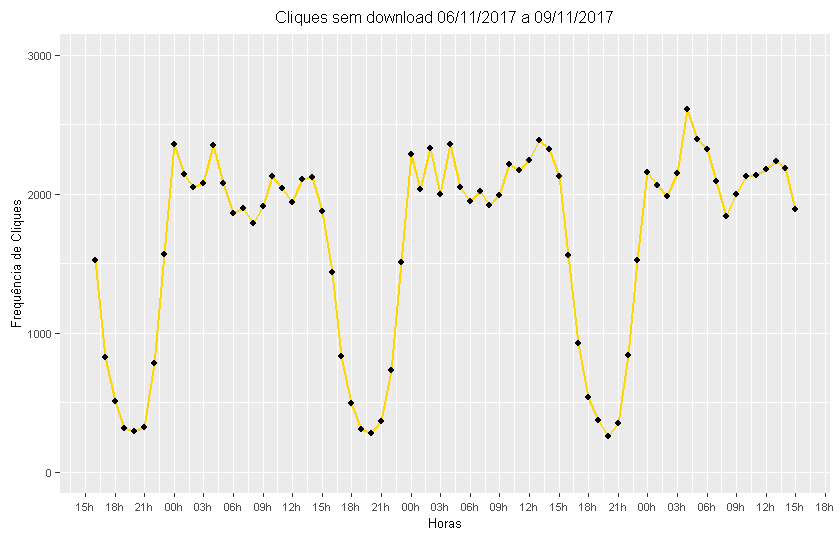

In [22]:
g6 <- ggplot(df_frequencia4, aes(x = Data_Horario2, y = Frequencia_cliques)) +
    geom_line(size = 0.7,colour = 'gold') +                    
    geom_point(size = 1.3, colour = 'black') +
    scale_x_datetime(labels = date_format(format = '%Hh', tz = "UTC"), date_breaks = "3 hours") +
    coord_cartesian(ylim = c(0, 3000)) +
    labs(x = 'Horas', y = 'Frequência de Cliques', title = 'Cliques sem download 06/11/2017 a 09/11/2017') +
    theme(plot.title = element_text(hjust = 0.5), text = element_text(size = 8))

options(repr.plot.width = 7, repr.plot.height = 4.5)
g6

No gráfico precebe-se que ocorrem picos de 00h00 às 14h00. Há um enorme crescimento de cliques sem download no período de 21h00 às 00h00 nos dias 6, 7 e 8 e uma queda enorme no período de 15h00 às 20h00 nos dias 7 e 8.

In [23]:
# AGRUPAMENTO POR HORA PARA SABER EM QUAL HORÁRIO SE TEM MAIS CLIQUES SEM DOWNLOADS
df_frequencia5 <- df_frequencia4 %>%
    separate (col = Data_Horario2, c ("Data2", "Hora"), sep = ' ', remove = TRUE)

df_frequencia6 <- df_frequencia5 %>%
             group_by(Hora) %>%
             summarise(Total_cliques = sum(Frequencia_cliques))

df_frequencia7 <- df_frequencia6 %>%
     separate(col = Hora, c ("Hora", "s", "m"), sep = ':', remove = TRUE) %>%
     select(Hora, Total_cliques)

head(df_frequencia7, 5)

Hora,Total_cliques
00,6803
01,6242
02,6365
03,6228
04,7322


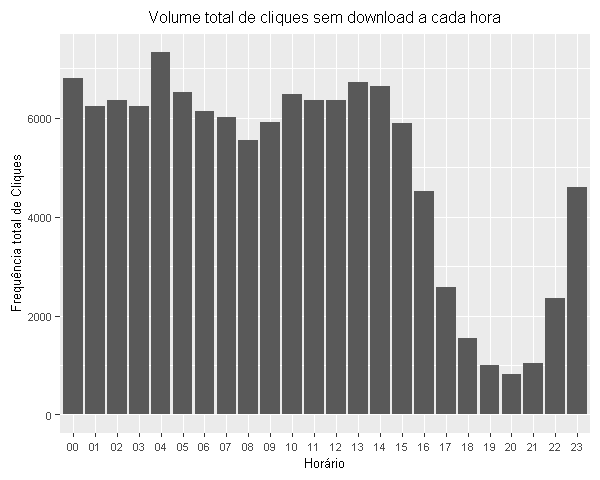

In [24]:
# HORÁRIOS COM MAIOR VOLUME DE CLIQUES SEM DOWNLOAD NOS TRÊS DIAS
g7 <- ggplot(df_frequencia7, aes(x = Hora, y = Total_cliques)) +
     geom_bar(stat ="identity") +
     labs(x = 'Horário', y = 'Frequência total de Cliques', title = 'Volume total de cliques sem download a cada hora') +
     theme(plot.title = element_text(hjust = 0.5), text = element_text(size = 8))

options(repr.plot.width = 5, repr.plot.height = 4)
g7

Nos horários de 23h00 até as 17h00 é quando mais se tem cliques sem download.

#### **SEPARANDO DADOS DE TREINO E TESTE**

In [25]:
set.seed(1908)

In [26]:
split <- sample.split(df_Talking_Data$Classe, SplitRatio = 0.7)
dados_treino <- subset(df_Talking_Data, split == TRUE)
dados_teste <- subset(df_Talking_Data, split == FALSE )

In [27]:
# DADOS TREINO 70%
str(dados_treino)

Classes 'data.table' and 'data.frame':	168000 obs. of  8 variables:
 $ IP              : int  43793 197004 55179 109065 55853 84725 143971 71710 75700 120471 ...
 $ App             : int  29 5 3 14 18 14 1 17 19 12 ...
 $ Dispositivo     : int  1 1 1 1 1 1 1 1 0 1 ...
 $ SO              : int  19 11 10 25 32 19 13 13 38 36 ...
 $ Canal           : int  213 113 280 379 121 379 153 128 282 409 ...
 $ Horario_clique  : POSIXct, format: "2017-11-08 14:38:44" "2017-11-08 10:21:20" ...
 $ Horario_download: POSIXct, format: "2017-11-08 14:47:49" "2017-11-08 10:21:49" ...
 $ Classe          : int  1 1 0 0 0 0 0 0 1 0 ...
 - attr(*, ".internal.selfref")=<externalptr> 


In [28]:
# DADOS TESTE 30%
str(dados_teste)

Classes 'data.table' and 'data.frame':	72000 obs. of  8 variables:
 $ IP              : int  95766 32453 314022 40241 106770 62879 88856 7156 14913 26995 ...
 $ App             : int  18 18 39 3 18 18 9 19 18 19 ...
 $ Dispositivo     : int  1 1 1 1 1 3032 1 0 1 0 ...
 $ SO              : int  20 18 19 8 20 607 25 21 19 50 ...
 $ Canal           : int  107 107 213 280 107 107 134 213 121 213 ...
 $ Horario_clique  : POSIXct, format: "2017-11-08 02:34:42" "2017-11-09 12:34:16" ...
 $ Horario_download: POSIXct, format: NA "2017-11-09 12:48:00" ...
 $ Classe          : int  0 1 1 0 0 0 0 1 0 1 ...
 - attr(*, ".internal.selfref")=<externalptr> 


In [29]:
# REMOVENDO AS VARIÁVEIS COM DATAS 
dados_treino <- dados_treino[, c(1:5, 8)]
dados_treino <- as.data.frame(dados_treino)
dados_teste <- dados_teste[, c(1:5, 8)]
dados_teste <- as.data.frame(dados_teste)

In [30]:
# TRANSFORMANDO AS VARIÁVEIS PARA FACTOR
dados_treino$Classe <- as.factor(dados_treino$Classe)
dados_treino$IP <- as.factor(dados_treino$IP)
dados_treino$App <- as.factor(dados_treino$App)
dados_treino$Dispositivo <- as.factor(dados_treino$Dispositivo)
dados_treino$SO <- as.factor(dados_treino$SO)
dados_treino$Canal <- as.factor(dados_treino$Canal)

In [31]:
dados_teste$Classe <- as.factor(dados_teste$Classe)
dados_teste$IP <- as.factor(dados_teste$IP)
dados_teste$App <- as.factor(dados_teste$App)
dados_teste$Dispositivo <- as.factor(dados_teste$Dispositivo)
dados_teste$SO <- as.factor(dados_teste$SO)
dados_teste$Canal <- as.factor(dados_teste$Canal)

### APRENDIZADO E AVALIAÇÃO DO MODELO

#### K - NEAREST NEIGHBOR

In [32]:
modelo_knn <- knn(train = dados_treino[, 1:5], test = dados_teste[, 1:5], cl = dados_treino[, 6], k = 5, prob = TRUE)

In [33]:
probabilidades <- attr(modelo_knn, "prob")

In [34]:
matriz_confusao_knn <- confusionMatrix(modelo_knn, dados_teste$Classe)
matriz_confusao_knn

Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0 29122  9137
         1  6878 26863
                                               
               Accuracy : 0.7776               
                 95% CI : (0.7745, 0.7806)     
    No Information Rate : 0.5                  
    P-Value [Acc > NIR] : < 0.00000000000000022
                                               
                  Kappa : 0.5551               
                                               
 Mcnemar's Test P-Value : < 0.00000000000000022
                                               
            Sensitivity : 0.8089               
            Specificity : 0.7462               
         Pos Pred Value : 0.7612               
         Neg Pred Value : 0.7962               
             Prevalence : 0.5000               
         Detection Rate : 0.4045               
   Detection Prevalence : 0.5314               
      Balanced Accuracy : 0.7776               
              

In [35]:
source("Metricas_classificacao.R")

In [36]:
metricas_class(0, table(Previsto = modelo_knn, Referencia = dados_teste$Classe), "Métricas K-Nearest Neighbor")

Métricas K-Nearest Neighbor 
 
Acuracia (Accuracy)          = 0.7776 
Recall (Sensitivity)         = 0.8089 
Precisao (Precision)         = 0.7612 
F1 Score (F-Score)           = 0.7843 
Especificidade (Specificity) = 0.7462

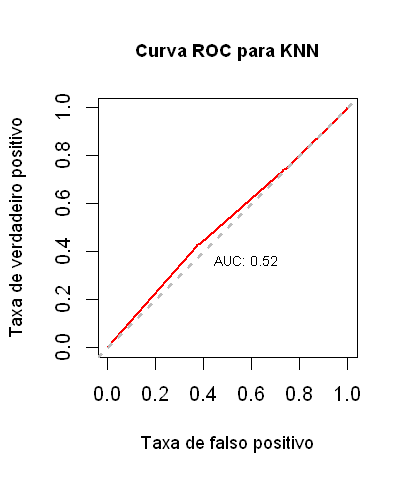

In [37]:
# CURVA ROC E AREA UNDER CURVE - AUC
prediction1 <- prediction(probabilidades, dados_teste$Classe)
tpr_fpr_knn <- performance(prediction1, "tpr","fpr")
auc_knn <- performance(prediction1, "auc")
auc_knn <- round(unlist(slot(auc_knn, "y.values")), 2)

options(repr.plot.width = 3.4, repr.plot.height = 4)
plot(tpr_fpr_knn, col = rainbow(9), 
     xlab = "Taxa de falso positivo", 
     ylab = "Taxa de verdadeiro positivo",
     main = "Curva ROC para KNN", 
     cex.lab = .9,   
     cex.main = .9,  
     lwd = 2 )
abline(a = 0, b = 1, lwd = 3, lty = 3, col = "gray")
legend(0.4, 0.4, legend = c(paste0("AUC: ", auc_knn)), cex = 0.7, bty = "n", box.col = "white")

#### NAIVE BAYES

In [38]:
modelo_nb <- naiveBayes(Classe ~ IP + App + Dispositivo + SO + Canal, dados_treino, laplace = 1)

In [39]:
# PREVISÃO DAS CLASSES
previsao_nb <- predict(modelo_nb, dados_teste, type = "class")

In [40]:
# PREVISÃO DAS PROBABILIDADES DAS CLASSES
previsao_nb_prob <- predict(modelo_nb, dados_teste, type = "raw")

In [41]:
matriz_confusao_nb <- confusionMatrix(previsao_nb, dados_teste$Classe)
matriz_confusao_nb

Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0 35288  5928
         1   712 30072
                                               
               Accuracy : 0.9078               
                 95% CI : (0.9056, 0.9099)     
    No Information Rate : 0.5                  
    P-Value [Acc > NIR] : < 0.00000000000000022
                                               
                  Kappa : 0.8156               
                                               
 Mcnemar's Test P-Value : < 0.00000000000000022
                                               
            Sensitivity : 0.9802               
            Specificity : 0.8353               
         Pos Pred Value : 0.8562               
         Neg Pred Value : 0.9769               
             Prevalence : 0.5000               
         Detection Rate : 0.4901               
   Detection Prevalence : 0.5724               
      Balanced Accuracy : 0.9078               
              

In [42]:
metricas_class(0, table(Previsto = previsao_nb, Referencia = dados_teste$Classe), "Métricas Naive Bayes")

Métricas Naive Bayes 
 
Acuracia (Accuracy)          = 0.9078 
Recall (Sensitivity)         = 0.9802 
Precisao (Precision)         = 0.8562 
F1 Score (F-Score)           = 0.914 
Especificidade (Specificity) = 0.8353

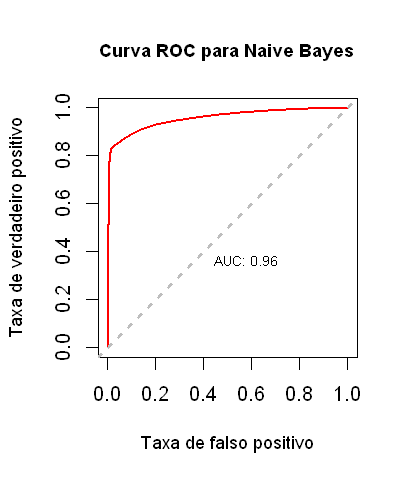

In [43]:
# CURVA ROC E AREA UNDER CURVE - AUC
prediction2 <- prediction(previsao_nb_prob[, 2], dados_teste$Classe)
tpr_fpr_nb <- performance(prediction2, "tpr","fpr")
auc_nb <- performance(prediction2, "auc")
auc_nb <- round(unlist(slot(auc_nb, "y.values")), 2)

options(repr.plot.width = 3.4, repr.plot.height = 4)
plot(tpr_fpr_nb, col = rainbow(9), 
     xlab = "Taxa de falso positivo", 
     ylab = "Taxa de verdadeiro positivo",
     main = "Curva ROC para Naive Bayes", 
     cex.lab = .9,   
     cex.main = .9,  
     lwd = 2 )
abline(a = 0, b = 1, lwd = 3, lty = 3, col = "gray")
legend(0.4, 0.4, legend = c(paste0("AUC: ", auc_nb)), cex = 0.7, bty = "n", box.col = "white")

#### CONCLUSÃO

As amostras coletadas do dataset train.csv permitiu a montagem de um dataset para treino e teste de forma balanceada com os dados originais sem que fosse necessário recorrer à dados sintéticos. Como o dataset train.csv do Kaggle possui em sua maioria instâncias da classe 0 (aplicativo não baixado) sendo quase 100% do dataset, foi realizada a coleta de dados de cada classe para que um dataset fosse montado de forma balanceada.

Na etapa de aprendizado foram utilizados os algoritmos Naive Bayes e KNN. O Naive Bayes obteve o melhor resultado.

Resultados Naive Bayes:

- O modelo atingiu uma **acurácia de 0.9078**. Das 72000 instâncias do dataset de teste, o modelo classificou corretamente 65360.
- O modelo acertou 35288 e errou 712 da soma entre verdadeiros positivos e falsos negativos, obtendo um **recall de 0.9802**, o que é importante para o problema, pois é preciso minimizar os falsos negativos. 
- Quanto a classe positiva, o modelo acertou 35288 (verdadeiros positivos) do total de verdadeiros positivos somados a falsos positivos. Uma **precisão de 0.8562**. A precisão é a capacidade de acertar os que não baixam o aplicativo.
- Quanto a classe negativa, o modelo acertou 30072 (verdadeiros negativos) do total de verdadeiros negativos somados a falsos positivos. Uma **especificidade 0.8353**. A especificidade é a taxa de verdadeiros negativos, ou seja, no caso é a capacidade de acertar os que baixam o aplicativo.
- A **média harmônica** entre precisão e recall foi de **0.9140**.
- A curva ROC com seus dois parâmetros, taxa de verdadeiro positivo (sensibilidade) e taxa de falso positivo ou probabilidade de alarme falso (1 — Specificity), mostrou que o desempenho do modelo com Naive Bayes foi bom com um **AUC de 0.96**.